<a href="https://colab.research.google.com/github/rpolea/CE888_project/blob/main/CE888_Assignment_2_model_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounts Google drive where all the images are stored in zip files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Unzips all the files into google colab
!unzip "/content/gdrive/My Drive/CE888_assignment/Test.zip"
!unzip "/content/gdrive/My Drive/CE888_assignment/Training.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Training/No_Fire/lake_resized_lake_frame1670.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1674.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1675.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1695.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1718.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1734.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1753.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1788.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1793.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1799.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1802.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1811.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1817.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame1829.jpg  
  inflating: Training/No_Fire/lake_resized_lake_frame

In [ ]:
#Imports all the libraries required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import ResNet101
from keras.applications import VGG16
from keras.applications import Xception
from keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
!pip install split-folders
import splitfolders

In [ ]:
#Splits the training directory using stratification to achieve an 80% training set and 20% validation
splitfolders.ratio("Training", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)
#Links the training set to the new training folder
train_set = 'output/train'
#Links the validation set to the new validation folder
val_set = 'output/val'
#Links the test set to the test folder
test_set = 'Test'

Copying files: 39375 files [00:09, 4081.12 files/s]


In [ ]:
#Prints the amount of images in the training, validation and test files to ensure the split has worked and all images are present
print('train fire images:', len(os.listdir('output/train/Fire')))
print('train no_fire images:', len(os.listdir('output/train/No_Fire')))

print('validation fire images:', len(os.listdir('output/val/Fire')))
print('validation no_fire images:', len(os.listdir('output/val/No_Fire')))

print('test fire images:', len(os.listdir('Test/Fire')))
print('test no_fire images:', len(os.listdir('Test/No_Fire')))

train fire images: 20014
train no_fire images: 11485
validation fire images: 5004
validation no_fire images: 2872
test fire images: 5137
test no_fire images: 3480


In [ ]:
#Batch size to be used throughout the project
batch_size = 32

#Numbers of images in each class for the training set to perform the weighting calculation
Fire_images = 20014
No_fire_images = 11485
Total_images = 31499

#Calculate the weights to solve class imbalance
Fire_weight = (1 / Fire_images)*(Total_images)/2.0 
No_fire_weight = (1 / No_fire_images)*(Total_images)/2.0
class_weight = {0: Fire_weight, 1: No_fire_weight}

#Prints the weights assigned
print('Weight for Fire: {:.2f}'.format(Fire_weight))
print('Weight for No_fire: {:.2f}'.format(No_fire_weight))

#Set early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

Weight for Fire: 0.79
Weight for No_fire: 1.37


In [ ]:
#Generates the training images and sets the augmentation techniques
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=90,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[0.5, 0.7])

print('Training')
#Pulls the images from the specified training directory and generates batches the augmented images
train_generator = train_datagen.flow_from_directory(
    train_set,
    #Image size kept at 254 by 254 to retain maximum information
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='binary',
    #Shuffles the training set to avoid influencing the model
    shuffle = True)

#Generates the validation images and rescales them
val_datagen = ImageDataGenerator(rescale=1./255)
print('Validation')
#Pulls the images from the specified validation directory
validation_generator = val_datagen.flow_from_directory(
    val_set,
    #Image size kept at 254 by 254 to retain maximum information
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

#Generates the test images and rescales them
test_datagen = ImageDataGenerator(rescale=1./255)
print('Test')
#Pulls the images from the specified test directory
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Training
Found 31499 images belonging to 2 classes.
Validation
Found 7876 images belonging to 2 classes.
Test
Found 8617 images belonging to 2 classes.


In [ ]:
#As all the models in this study have the same structure this function takes the model type as an input (ResNet etc)
#It then adds on the common layers, compiles the loss, optimiser and training metric and returns the full model structure

def model_structure(models):
  model = Sequential()
  #.add(models) takes the initial transfer learning structure passed through the function
  model.add(models)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00005),
              metrics=['accuracy'])
  return model

In [ ]:
#This function takes the fitted model and plots the training/validation loss and accuracy
def model_eval(models):
  #Loss plot
  plt.plot(models.history['loss'])
  plt.plot(models.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  #Accuracy plot
  plt.plot(models.history['accuracy'])
  plt.plot(models.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
#This function takes the full model structure, fits the generator and specifies the training structure
def model_fit(models):
  history = models.fit(
      train_generator,
      epochs = 10,
      #This ensures the number of steps covers all images at batch size 32
      steps_per_epoch = train_generator.samples // 32,
      validation_steps = validation_generator.samples // 32,
      validation_data = validation_generator,
      callbacks = early_stop)
  return history

In [ ]:
#This function takes the model after it has been trained and predicts on the test set
#It rounds the predictions from the test set to 0 or 1 for classification
#It defines the test labels needed for evaluation and class_labels are the names e.g. Fire, No Fire
def predict(models):
  predictions = models.predict(test_generator)
  class_predictions = np.where(predictions>=0.5, 1, 0)
  test_labels = test_generator.classes 
  class_labels = list(test_generator.class_indices.keys())
  return class_predictions, test_labels, class_labels

In [ ]:
#This function takes the predictions and labels and produces a classsification report and confusion matrix
def eval_metrics(class_predictions, test_labels, class_labels):
  print(classification_report(test_labels, class_predictions, target_names= class_labels))
  conf_matrix = confusion_matrix(test_labels, class_predictions)
  confdisplay = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = class_labels)
  confdisplay = confdisplay.plot(values_format = '.0f')

In [ ]:
#This section of code pulls in the DenseNet structure without the classifier and specifies the input shape
dn = DenseNet121(include_top=False, input_shape=(254,254,3))
#The functions for model structure, fitting and predictions are all called using DenseNet
dense = model_structure(dn)
dense_history = model_fit(dense)
dense_predictions, test_labels, class_labels = predict(dense)

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/10
984/984 [==============================] - 759s 725ms/step - loss: 0.0887 - accuracy: 0.9621 - val_loss: 0.0116 - val_accuracy: 0.9953
Epoch 2/10
984/984 [========

              precision    recall  f1-score   support

        Fire       0.99      0.86      0.92      5137
     No_Fire       0.82      0.99      0.90      3480

    accuracy                           0.91      8617
   macro avg       0.91      0.92      0.91      8617
weighted avg       0.92      0.91      0.91      8617



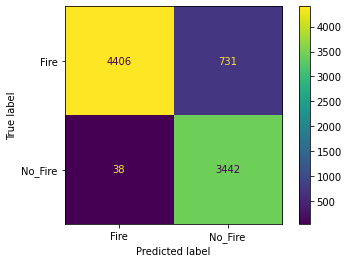

In [ ]:
#Takes the predictions and produces the classification report/confusion matrix for DenseNet
eval_metrics(dense_predictions, test_labels, class_labels)

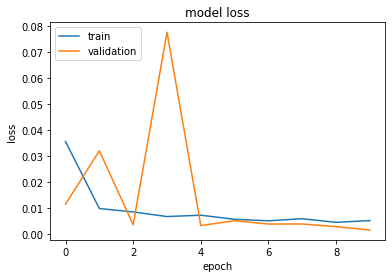

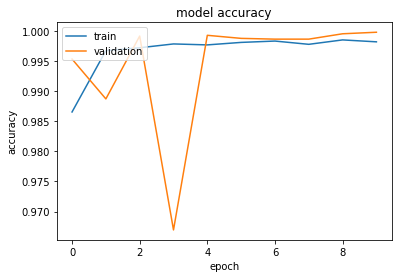

In [ ]:
#Takes the history from the training of the DenseNet model and plots the loss/accuracy per epoch
model_eval(dense_history)

In [ ]:
#This section of code pulls in the ResNet structure without the classifier and specifies the input shape
rn = ResNet101(
    include_top=False,
    input_shape=(254,254,3))
#The functions for model structure, fitting and predictions are all called using ResNet
res = model_structure(rn)
res_history = model_fit(res)
res_predictions, test_labels, class_labels = predict(res)

171450368/171446536 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 8, 8, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 42,660,225
Trainable params: 42,554,881
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/10
984/984 [==============================] - 1611s 2s/step - loss: 0.0593 - accuracy: 0.9767 - val_loss: 1.3800 - val_accuracy: 0.6204
Epoch 2/10
984/984 [=====

              precision    recall  f1-score   support

        Fire       1.00      0.68      0.81      5137
     No_Fire       0.68      1.00      0.81      3480

    accuracy                           0.81      8617
   macro avg       0.84      0.84      0.81      8617
weighted avg       0.87      0.81      0.81      8617



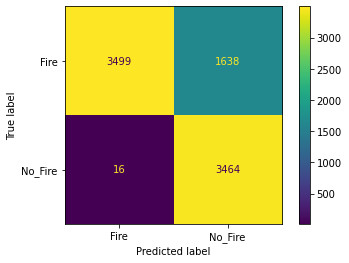

In [ ]:
#Takes the predictions and produces the classification report/confusion matrix for ResNet
eval_metrics(res_predictions, test_labels, class_labels)

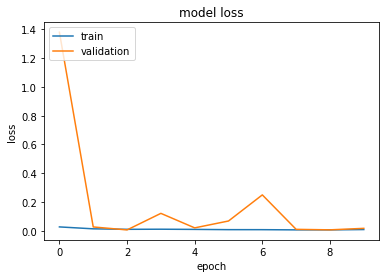

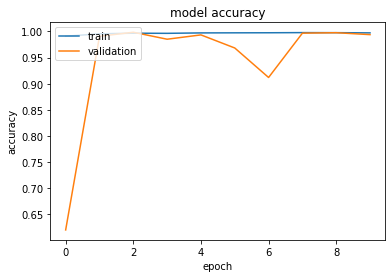

In [ ]:
#Takes the history from the training of the ResNet model and plots the loss/accuracy per epoch
model_eval(res_history)

In [ ]:
#This section of code pulls in the VGG16 structure without the classifier and specifies the input shape
vgg16 = VGG16(
    include_top=False,
    input_shape=(254,254,3))
#The functions for model structure, fitting and predictions are all called using VGG16
vgg = model_structure(vgg16)
vgg_history = model_fit(vgg)
vgg_predictions, test_labels, class_labels = predict(vgg)

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
984/984 [==============================] - 620s 609ms/step - loss: 0.1500 - accuracy: 0.9454 - val_loss: 0.1601 - val_accuracy: 0.9644
Epoch 2/10
984/984 [===========

              precision    recall  f1-score   support

        Fire       0.87      0.85      0.86      5137
     No_Fire       0.78      0.82      0.80      3480

    accuracy                           0.84      8617
   macro avg       0.83      0.83      0.83      8617
weighted avg       0.84      0.84      0.84      8617



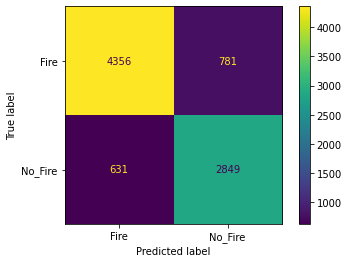

In [ ]:
#Takes the predictions and produces the classification report/confusion matrix for VGG16
eval_metrics(vgg_predictions, test_labels, class_labels)

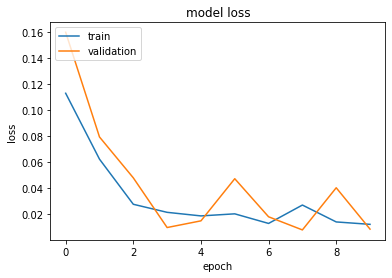

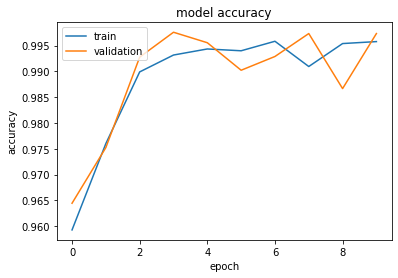

In [ ]:
#Takes the history from the training of the VGG16 model and plots the loss/accuracy per epoch
model_eval(vgg_history)

In [ ]:
#This section of code pulls in the Xception structure without the classifier and specifies the input shape
xception = Xception(
    include_top=False,
    input_shape=(254,254,3))
#The functions for model structure, fitting and predictions are all called using Xception
xcpt = model_structure(xception)
xcpt_history = model_fit(xcpt)
xcpt_predictions, test_labels, class_labels = predict(xcpt)

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
984/984 [==============================] - 695s 701ms/step - loss: 0.0976 - accuracy: 0.9689 - val_loss: 0.0558 - val_accuracy: 0.9816
Epoch 2/10
984/984 [====

              precision    recall  f1-score   support

        Fire       0.93      0.83      0.87      5137
     No_Fire       0.78      0.90      0.84      3480

    accuracy                           0.86      8617
   macro avg       0.85      0.86      0.85      8617
weighted avg       0.87      0.86      0.86      8617



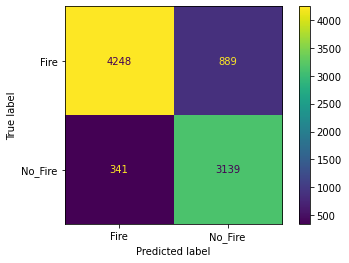

In [ ]:
#Takes the predictions and produces the classification report/confusion matrix for Xception
eval_metrics(xcpt_predictions, test_labels, class_labels)

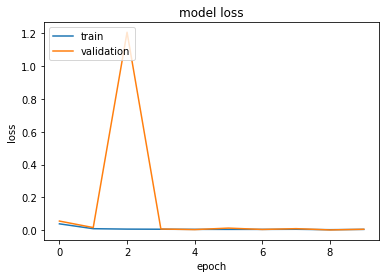

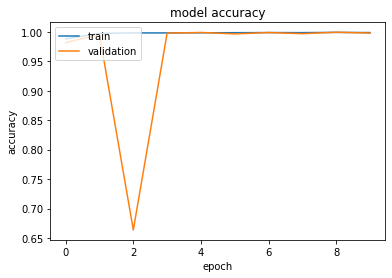

In [ ]:
#Takes the history from the training of the Xception model and plots the loss/accuracy per epoch
model_eval(xcpt_history)

In [ ]:
#This function takes the full model structure, fits the generator and specifies the training structure
#It is the same as the function above but includes the class weights
def weight_model_fit(models):
  history = models.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // 32,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // 32,
      epochs = 10,
      class_weight = class_weight,
      callbacks = early_stop)
  return history

In [ ]:
#This section of code pulls in the DenseNet structure without the classifier and specifies the input shape
weights_dn = DenseNet121(include_top=False, input_shape=(254,254,3))
#The functions for model structure (including weights), fitting and predictions are all called using DenseNet
dense_weight = model_structure(weights_dn)
dense_weight_history = weight_model_fit(dense_weight)
dense_weight_predictions, test_labels, class_labels = predict(dense_weight)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/10
984/984 [==============================] - 594s 594ms/step - loss: 0.0840 - accuracy: 0.9670 - val_loss: 0.0073 - val_accuracy: 0.9978
Epoch 2/10
984/984 [==============================] - 586s 595ms/step - loss: 0.0107 - accu

              precision    recall  f1-score   support

        Fire       1.00      0.60      0.75      5137
     No_Fire       0.63      1.00      0.77      3480

    accuracy                           0.76      8617
   macro avg       0.81      0.80      0.76      8617
weighted avg       0.85      0.76      0.76      8617



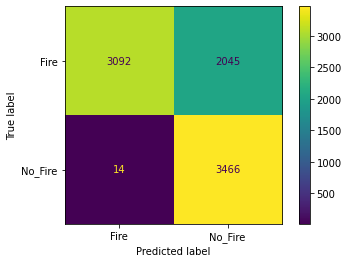

In [ ]:
#Takes the predictions and produces the classification report/confusion matrix for the weighted DenseNet
eval_metrics(dense_weight_predictions, test_labels, class_labels)

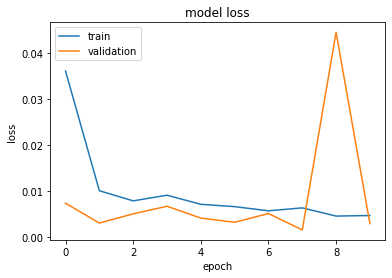

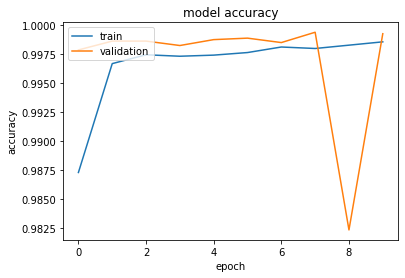

In [ ]:
#Takes the history from the training of the weighted DenseNet model and plots the loss/accuracy per epoch
model_eval(dense_weight_history)